In [1]:
import os

In [2]:
os.chdir('../..')

In [3]:
import convokit
from convokit import Corpus, download, TriadMotif, Thread
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

In [4]:
corpus_dir = "/sauna/fake-news/one_month"

In [5]:
corpus_names = os.listdir(corpus_dir)

In [6]:
corpus_names

['news-onemonth-corpus',
 'politics-onemonth-corpus',
 'worldnews-onemonth-corpus',
 'askscience-onemonth-corpus',
 'AskCulinary-onemonth-corpus',
 'AskWomen-onemonth-corpus',
 'WTF-onemonth-corpus',
 'gifs-onemonth-corpus',
 'funny-onemonth-corpus']

In [10]:
corpus1 = Corpus(filename=os.path.join(corpus_dir, corpus_names[6]))
corpus2 = Corpus(filename=os.path.join(corpus_dir, corpus_names[7]))
corpus3 = Corpus(filename=os.path.join(corpus_dir, corpus_names[8]))

In [11]:
corpus = corpus1.merge(corpus2).merge(corpus3)

In [12]:
corpus.print_summary_stats()

Number of Users: 437987
Number of Utterances: 1605106
Number of Conversations: 81819


In [13]:
threads = corpus.utterance_threads(include_root=False)

In [14]:
print(len(threads))

643470


## Initialize thread objects

In [15]:
thread_objs = dict()
fails = []
for thread_id, thread_utts in threads.items():
    thread_obj = Thread(list(thread_utts.values()))
    if thread_obj.check_integrity(verbose=False):
        thread_objs[thread_id] = thread_obj
        thread_obj.annotate_depth()

In [16]:
print("Broken threads", len(threads) - len(thread_objs))

Broken threads 2443


## Initialize thread hypergraphs

In [17]:
threads = corpus.utterance_threads(include_root=False)
threads_hypergraphs = dict()
for i, (root, thread) in enumerate(threads.items()):
    G = convokit.HyperConvo._make_hypergraph(uts=thread)
    threads_hypergraphs[root] = G

## Some descriptive stats on the top-level comment threads from 1 Oct 2017 - 1 Oct 2018

In [18]:
# Number of threads
len(thread_objs)

641027

## Distribution of number of participants in the threads

In [19]:
from collections import defaultdict
threads_num_users = defaultdict(int)
for thread_id, hg in threads_hypergraphs.items():
    threads_num_users[len(hg.hypernodes)] += 1

In [20]:
sorted(list(threads_num_users.items()))[:20]

[(1, 516155),
 (2, 68261),
 (3, 21708),
 (4, 10039),
 (5, 5667),
 (6, 3619),
 (7, 2486),
 (8, 2004),
 (9, 1517),
 (10, 1157),
 (11, 893),
 (12, 851),
 (13, 704),
 (14, 595),
 (15, 580),
 (16, 483),
 (17, 415),
 (18, 373),
 (19, 324),
 (20, 290)]

In [21]:
# convokit.display_thread(threads, 'e58r4yf')

In [22]:
from itertools import permutations
def identify_final_motif(hg, userA, userB, userC):
    # We use the identities of user A, B, C (i.e. top-level-commenter, first replier, first third-party replier)
    # to simplify the typically-difficult final motif identification step
    num_edge_dirs = 0
    for user_pair in permutations([userA, userB, userC], 2):
        if len(hg.adj_in[user_pair[0]].get(user_pair[1], [])) > 0:
            num_edge_dirs += 1
    
    # sanity check
    assert 2 <= num_edge_dirs <= 6
    if num_edge_dirs == 6:
        return 'TRIRECIPROCAL_TRIADS'
    elif num_edge_dirs == 5:
        return 'DIRECIPROCAL_2TO3_TRIADS'
    elif num_edge_dirs == 4:
        if len(hg.adj_out[userB].get(userC, [])) == 0 and len(hg.adj_out[userC].get(userB, [])) == 0:
            # B and C do not talk
            return "DIRECIPROCAL_TRIADS"
        elif len(hg.adj_out[userB].get(userC, [])) > 0 and len(hg.adj_out[userC].get(userB, [])) > 0:
            # B and C talk to each other
            return "INCOMING_RECIPROCAL_TRIADS"
        elif len(hg.adj_out[userC].get(userB, [])) > 0 and len(hg.adj_out[userC].get(userA, [])) > 0 and \
                len(hg.adj_in[userC].get(userB, [])) == 0 and len(hg.adj_in[userC].get(userA, [])) == 0:
            # C talks to A and B but gets no responses
            return "OUTGOING_RECIPROCAL_TRIADS"
        elif len(hg.adj_out[userB].get(userC, [])) > 0 and len(hg.adj_out[userB].get(userA, [])) > 0 and \
                len(hg.adj_in[userB].get(userC, [])) == 0 and len(hg.adj_in[userC].get(userA, [])) == 0:
            # B talks to A and C but gets no response
            return "OUTGOING_RECIPROCAL_TRIADS"
        else:
            return "DIRECTED_CYCLE_1TO3_TRIADS"
    elif num_edge_dirs == 3:
        if len(hg.adj_in[userC].get(userA, [])) > 0: # A talks to C
            if len(hg.adj_in[userA].get(userC, [])) > 0: # C talks to A
                return "INCOMING_1TO3_TRIADS"
            else: # C does not talk to A
                return "DIRECTED_CYCLE_TRIADS"
        else: # A does not tak to C
            if len(hg.adj_out[userC].get(userB, [])) > 0: # C talks to B
                return "OUTGOING_3TO1_TRIADS"
            else:
                return "INCOMING_2TO3_TRIADS"
    elif num_edge_dirs == 2:
        # cannot be outgoing by definition, can only be incoming or unidirectional
        if len(hg.adj_in[userA].get(userC, [])) > 0:
            return 'INCOMING_TRIADS'
        else:
            return 'UNIDIRECTIONAL_TRIADS'

        

In [23]:
broken_threads = []
one_commenter_threads = []
two_commenter_threads = []
three_or_more_threads = []
for thread_id, thread_obj in thread_objs.items():
    hg = threads_hypergraphs[thread_id]
    if not thread_obj.check_integrity(verbose=False):
        broken_threads.append(thread_id)
        continue
    userA, userB, userC = thread_obj.identify_ABC()
    if userB is None:
        one_commenter_threads.append(thread_id)
    elif userC is None:
        density = thread_obj.get_AB_density(userA, userB)
        two_commenter_threads.append((thread_id, 'DYADIC_TRIADS', density, -1, "nil"))
    else:
        final_type = identify_final_motif(hg, thread_obj.get_user(userA), 
                                          thread_obj.get_user(userB), thread_obj.get_user(userC))
#         print(userA, userB, userC)
        density = thread_obj.get_AB_density_beforeC(userA, userB, userC)
        C_depth, target = thread_obj.get_C_entrance(userA, userB, userC) 
        three_or_more_threads.append((thread_id, final_type, density, C_depth, target))
        

In [24]:
print("Total threads", len(threads))
print("threads with one commenter", len(one_commenter_threads))
print("threads with two commenters", len(two_commenter_threads))
print("threads with >=3 commenters", len(three_or_more_threads))
print("threads with broken structure", len(threads) - len(one_commenter_threads) - len(two_commenter_threads) - len(three_or_more_threads))

Total threads 643470
threads with one commenter 514631
threads with two commenters 67769
threads with >=3 commenters 58627
threads with broken structure 2443


Let **C_depth** be defined as the depth of the top-level-comment tree that C's first utterance is located at. The top-level-comment has depth 1, so if C responds to the top-level-comment directly, then C_depth = 2.

Let **density** be the number of utterances directed from A to B or B to A. For non-dyadic threads (i.e. threads with >=3 users), this is the density before C first arrives. (Note: self-replies are not counted.)

Let **C_target** be the speaker of the utterance that C first responds to.

In [25]:
df = pd.DataFrame(data=two_commenter_threads+three_or_more_threads, columns=['thread_id', 'motif_type', 'density', 'C_depth', 'C_target'])

In [26]:
df = df.set_index('thread_id')

In [27]:
df.head()

,motif_type,density,C_depth,C_target
thread_id,,,,
e56q593,DYADIC_TRIADS,2,-1,nil
e56q6u6,DYADIC_TRIADS,2,-1,nil
e56qkzc,DYADIC_TRIADS,2,-1,nil
e56qm39,DYADIC_TRIADS,2,-1,nil
e56qmam,DYADIC_TRIADS,3,-1,nil


In [28]:
Counter(df['motif_type'])

Counter({'DYADIC_TRIADS': 67769,
         'UNIDIRECTIONAL_TRIADS': 17039,
         'OUTGOING_3TO1_TRIADS': 7119,
         'INCOMING_TRIADS': 21978,
         'DIRECIPROCAL_TRIADS': 2338,
         'INCOMING_2TO3_TRIADS': 5113,
         'INCOMING_RECIPROCAL_TRIADS': 1174,
         'INCOMING_1TO3_TRIADS': 2963,
         'DIRECIPROCAL_2TO3_TRIADS': 204,
         'DIRECTED_CYCLE_1TO3_TRIADS': 219,
         'OUTGOING_RECIPROCAL_TRIADS': 146,
         'DIRECTED_CYCLE_TRIADS': 302,
         'TRIRECIPROCAL_TRIADS': 32})

In [29]:
sorted(list(Counter(df[df['motif_type'] != 'DYADIC_TRIADS']['density']).items()))[:30]

[(1, 14),
 (2, 50416),
 (3, 6170),
 (4, 1232),
 (5, 443),
 (6, 171),
 (7, 70),
 (8, 50),
 (9, 18),
 (10, 13),
 (11, 11),
 (12, 5),
 (14, 2),
 (15, 2),
 (16, 2),
 (19, 2),
 (21, 1),
 (22, 2),
 (26, 1),
 (33, 1),
 (43, 1)]

In [30]:
Counter(df['C_target'])

Counter({'nil': 67769, 'B': 25718, 'A': 32909})

In [31]:
Counter(df['density'])

Counter({2: 104497,
         3: 15701,
         4: 3671,
         7: 240,
         6: 561,
         5: 1303,
         10: 55,
         9: 84,
         8: 149,
         14: 15,
         22: 4,
         13: 5,
         11: 43,
         35: 1,
         16: 8,
         23: 2,
         12: 22,
         20: 1,
         18: 1,
         17: 2,
         15: 5,
         24: 1,
         29: 1,
         60: 1,
         19: 3,
         27: 2,
         1: 14,
         21: 1,
         43: 1,
         26: 1,
         33: 1})

## C joins vs C does not join at each density k

In [32]:
no_dyadic_df = df[df['motif_type'] != 'DYADIC_TRIADS']

In [33]:
no_dyadic_df.shape

(58627, 4)

In [34]:
dyadic_df = df[df['motif_type'] == 'DYADIC_TRIADS']

In [35]:
C_joins_percent = []
for k in range(2, 11):
    C_join_num = no_dyadic_df[no_dyadic_df['density'] == k].shape[0]
    C_no_join_num_dyadic = dyadic_df[dyadic_df['density'] >= k].shape[0]
    C_no_join_num_others = no_dyadic_df[no_dyadic_df['density'] > k].shape[0]
    C_no_join = C_no_join_num_dyadic + C_no_join_num_others
    C_joins_percent.append(C_join_num / (C_join_num + C_no_join))

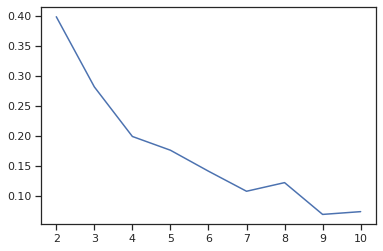

In [36]:
sns.lineplot(x=range(2,11), y=C_joins_percent)

## Which part of the thread does C join?

### Basic counts of C's depth

In [37]:
ctr = Counter(no_dyadic_df['C_depth'])

In [38]:
num_instances = [ctr[x] for x in range(2, 11)]

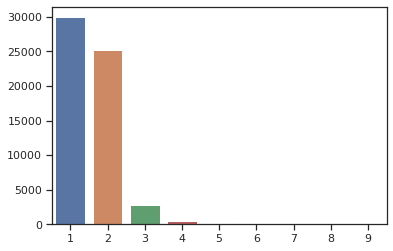

In [39]:
# Num instances against depth of comment C responds to (1 = top-level-comment)
sns.barplot(x=list(range(1,10)), y=num_instances)

### Plotting which part of the thread C (C's depth) joins against density before C's entrance

In [40]:
no_dyadic_df.groupby('density').mean()

,C_depth
density,
1,2.000000
2,2.465170
3,3.005024
4,3.492695
5,4.069977
6,4.362573
7,5.600000
8,5.980000
9,7.166667


In [41]:
y = no_dyadic_df.groupby('density').mean().values[1:10].flatten() # exclude density == 1 (edge cases)

In [42]:
x = range(2, 11)

Text(0.5, 1.0, 'C_depth against density')

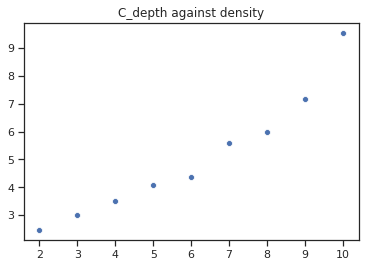

In [43]:
# C's depth against A/B density before C enters
sns.scatterplot(x=x, y=y).set_title('C_depth against density')

Text(0.5, 1.0, '(C_depth - density) against density')

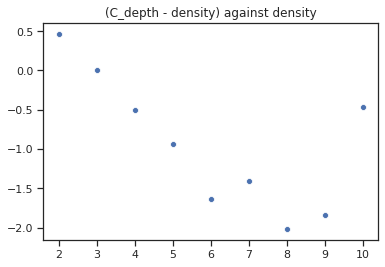

In [44]:
sns.scatterplot(x=x, y=y-x).set_title('(C_depth - density) against density')

### How does C's depth on joining correlate to the final motif?

In [45]:
triad_order = convokit.TriadMotif.get_motif_types()

In [46]:
motif_to_Cdepth = df.groupby('motif_type')['C_depth'].mean().to_dict()

In [47]:
y = [motif_to_Cdepth[motif] for motif in triad_order if motif in motif_to_Cdepth]

In [48]:
triad_order

['NO_EDGE_TRIADS',
 'SINGLE_EDGE_TRIADS',
 'INCOMING_TRIADS',
 'OUTGOING_TRIADS',
 'DYADIC_TRIADS',
 'UNIDIRECTIONAL_TRIADS',
 'INCOMING_2TO3_TRIADS',
 'DIRECTED_CYCLE_TRIADS',
 'INCOMING_1TO3_TRIADS',
 'OUTGOING_3TO1_TRIADS',
 'INCOMING_RECIPROCAL_TRIADS',
 'OUTGOING_RECIPROCAL_TRIADS',
 'DIRECTED_CYCLE_1TO3_TRIADS',
 'DIRECIPROCAL_TRIADS',
 'DIRECIPROCAL_2TO3_TRIADS',
 'TRIRECIPROCAL_TRIADS']

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

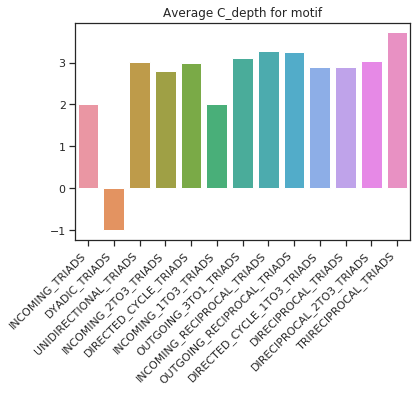

In [49]:
sns.barplot(x=[motif for motif in triad_order if motif in motif_to_Cdepth], y=y)
plt.title('Average C_depth for motif')
plt.xticks(rotation=45, horizontalalignment='right')

In [50]:
motif_to_Cdepth

{'DIRECIPROCAL_2TO3_TRIADS': 3.0392156862745097,
 'DIRECIPROCAL_TRIADS': 2.8892215568862274,
 'DIRECTED_CYCLE_1TO3_TRIADS': 2.8995433789954337,
 'DIRECTED_CYCLE_TRIADS': 3.0,
 'DYADIC_TRIADS': -1.0,
 'INCOMING_1TO3_TRIADS': 2.005399932500844,
 'INCOMING_2TO3_TRIADS': 2.7926853119499317,
 'INCOMING_RECIPROCAL_TRIADS': 3.2691652470187393,
 'INCOMING_TRIADS': 2.0025025025025025,
 'OUTGOING_3TO1_TRIADS': 3.114763309453575,
 'OUTGOING_RECIPROCAL_TRIADS': 3.2465753424657535,
 'TRIRECIPROCAL_TRIADS': 3.71875,
 'UNIDIRECTIONAL_TRIADS': 3.0038734667527436}

### C_target against C_depth 

Note that we expect an obvious correlation between the two.

In [51]:
C_target_grouped_by_depth = no_dyadic_df.groupby('C_depth')['C_target'].value_counts(normalize=True).unstack()

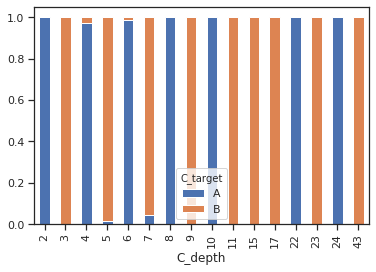

In [52]:
C_target_grouped_by_depth.plot(kind='bar',stacked=True)

### Alternate view: C_depth against C_target

In [53]:
C_depth_grouped_by_target = no_dyadic_df.groupby('C_target')['C_depth'].value_counts(normalize=True).unstack()

In [54]:
C_depth_grouped_by_target.T

C_target,A,B
C_depth,,
2,0.910085,NaN
3,0.002066,0.975776
4,0.080920,0.002994
5,0.000243,0.017420
6,0.005196,0.000078
7,0.000091,0.002489
8,0.000972,NaN
9,NaN,0.000622
10,0.000365,NaN
